# TRABAJO PRACTICO N°2

## Ejercicio 1

Basándose en los trabajos
- Performance Modelling of Imaging Service or Earth Observation Satellites with Two-dimensional Markov
Chain
- Queuing theory application in imaging service analysis for small Earth observation satellites
Se pide implementar las soluciones propuestas por los autores utilizando Cadenas de Markov, y Teoría de Colas,
considerando:

__a)__ Utilizar el generador de números al azar implementado en el Trabajo Práctico 1 para generar los números al
azar utilizados en el ejercicio (comparar los resultados con los obtenidos si se utilizan los números al azar
provistos por el lenguaje elegido).

__b)__ Probar distintos escenarios

__c) Opcional__: Comparar los resultados obtenidos, con los resultados que se obtendrían con un Generador
Congruencial Lineal de módulo $2^{32}$, multiplicador 1013904223, incremento de 1664525 y semilla igual a la
parte entera del promedio de los números de padrón de los integrantes del grupo

### <span style="color:red">Resolucion Ejercicio 1</span>

In [4]:
import time

__GCL generado en el Trabajo Practico 1__

In [1]:
# PAPER 1
class xorshift:
  max64bit = (2**64) 
 
  def __init__(self,seed):
    self.seed = seed % self.max64bit

  def rand(self):
    # a=13 b=7 c=17
    # Python no tiene limite de valores para int asi que aplico modulo de 64 bits
    # para simular el comportamiento de C y tener periodo de (2^64 - 1) ----> Confirmado: Hay que imitar la implementacion del paper
    self.seed = (self.seed ^ (self.seed << 13)) % self.max64bit
    self.seed = (self.seed ^ (self.seed >> 7)) % self.max64bit
    self.seed = (self.seed ^ (self.seed << 17)) % self.max64bit
    
    return self.seed

  # Dividimos por el módulo para obtener valores en [0,1]
  def uniform_rand(self):
    return self.rand()/self.max64bit

In [5]:
rng = xorshift(int(time.time()))
df_rng = [rng.rand() for i in range(1000)]
df_rng_uniform = [rng.uniform_rand() for i in range(1000)]

**Generador opcional**

Generador Congruencial Lineal (GCL) de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera del promedio de los números de padrón de los integrantes del grupo.

El método Lineal Congruente funciona de la siguiente manera:

<font size = 4> 
$$
{X}_{n+1}=(aX_n + c)~mod~m, ~~~n>=0 \\
m, ~the~ modulus, ~0<m\\
a, ~the~ multiplier, ~0<=a<m\\
c, ~the~ increment, ~0<=c<m\\
X_0, ~the~ starting~ value, ~0<=X_0<m \\
$$
</font>

A partir de esto generaremos el generador GCL con los datos provistos

In [8]:
class RandOp:
    
    # m:modulus
    # a:multiplier
    # c:increment
    m = 2**32
    a = 1013904223
    c = 1664525
    xn = int((97576+93956+104093+96444+98408)/5)
    
    def rand(self):
        self.xn = (self.a*self.xn + self.c)%self.m
        return self.xn
    
    # Dividimos por el módulo para obtener valores en [0,1]
    def uniform_rand(self):
        return self.rand()/self.m

In [9]:
randOp= RandOp()
randoms= [randOp.rand() for i in range(1000)]
randoms_uniform = [randOp.uniform_rand() for i in range(1000)]

## Ejercicio 2
Utilizar Simpy para simular una sección del ejercicio 1 a elección

### <span style="color:red">Resolucion Ejercicio 2</span>

## Ejercicio 3
Un servidor recibe solicitudes las cuales son procesadas de una por vez en el orden de llegada (política FIFO).
Se determinó que en 10 milisegundos existe una probabilidad p =1/40 que llegue una nueva solicitud y una probabilidad q = 1/30 que una solicitud termine de ser procesada y deje el sistema.

Se desea estudiar la cantidad de solicitudes en el servidor considerando tanto las que están en cola esperando ser
procesadas como la solicitud que está siendo procesada.

__a.__ Determine la matriz de transición de estados explicando cómo se obtiene la misma.

__b.__ Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos. Suponga que el
sistema puede tener como máximo 30 estados posibles y que el servidor comienza sin estar procesando solicitudes.

__c.__ Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

__d.__ Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

__e.__ Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

### <span style="color:red">Resolucion Ejercicio 3</span>

__a.__ Determine la matriz de transición de estados explicando cómo se obtiene la misma:

La matriz de transción de estados se puede obtener si pensamos a cada estado como la suma entre la cantidad de solicitudes esperando ser procesadas más la solicitud siendo procesada.

Suponiendo que en 10 milisegundos no puede arribar más de 1 solicitud ni que más de 1 solicitud salga del sistema ni que una misma solicitud entre y salga en la misma fracción, podemos definir 3 transiciones posibles por fracción de tiempo para cada estado:

- la cantidad total de solicitudes __aumenta en 1__  si arriba una solicitud al servidor y no sale ninguna.


- la cantidad total de solicitudes __disminuye en 1__  si una solicitud deja el sistema y no ingresa ninguna.


- la cantidad total de solicitudes __se mantiene igual__ si:

    - una solicitud llega al servidor y otra sale
    
    - no llega ni sale ninguna solicitud del servidor

Teniendo las siguientes probabilidades:

Probabilidad de arribo(Pa)= 1/40

Probabilidad de salida(Ps) = 1/30

Pn-1 = Probabilidad de que no arribe ninguna solicitud (1-Pa) * Probabilidad de que egrese una solicitud del sistema (Ps) 

Pn+1 = Probabilidad de que no egrese ninguna solicitud (1-Ps) * Probabilidad de que arribe una solicitud al sistema (Pa)

Pn = Probabilidad de que no egrese ni ingrese ninguna solicitud (1-Ps) * (1-Pa) + Probabilidad de que ingrese una solicitud y egrese otra (Ps * Pa)

Cuando n=0 es un caso particular ya que al no haber niguna solicitud en el sistema (ni siendo procesada ni en cola) solo se puede avanzar hacia el estado n=1 con probabilidad Pa y mantenerse en n=0 con probabilidad (1-Pa) 

Visualizamos de la siguiente manera:

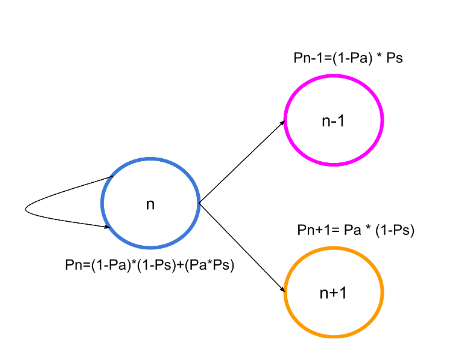

La matriz de transicion de estados queda de la forma:

$$P = \begin{bmatrix}
1-P_{a} & P_{a} & 0 & 0 & ...\\
P_{n-1} & P_{n} & P_{n+1} & 0 & ...\\
0 & P_{n-1} & P_{n} & P_{n+1} & ...\\
0 & 0 & P_{n-1} & P_{n} & ...\\
... & ... & ... & ... & ... \\
\end{bmatrix}$$

con n: cantidad máxima de solicitudes que puede procesar el sistema

__b.__ Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos. Suponga que el sistema puede tener como máximo 30 estados posibles y que el servidor comienza sin estar procesando solicitudes.

In [134]:
import random as rn
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [140]:
def simulacion(tiempo,step):
    Pa = 1/40
    Ps = 1/30
    estado = 0
    solicitudes_totales = 0
    tiempos = []
    cant_solicitudes_x_fraccion = []
    tiempo_sin_solicitudes = 0
    for x in range(0, tiempo * 1000, step):
        u = rn.random()
        if (estado == 0):
            if (u > 1-Pa): #ingresa solicitud
                solicitudes_totales += 1
                estado += 1
            else:
                tiempo_sin_solicitudes += step
        else:
            if (u <= (Ps*(1-Pa))):#egresa solicitud
                estado -= 1
            elif (u > 1 - (Pa*(1-Ps))): #ingresa solicitud
                solicitudes_totales += 1
                estado += 1
        tiempos.append(x)
        cant_solicitudes_x_fraccion.append(estado)   
        
    return tiempos, cant_solicitudes_x_fraccion, solicitudes_totales, tiempo_sin_solicitudes

In [141]:
tiempos, cant_solicitudes_x_fraccion, total_solicitudes_procesadas, tiempo_sin_solicitudes = simulacion(1000, 10)

__c.__ Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

b. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.


Text(0, 0.5, 'Cantidad de Solicitudes')

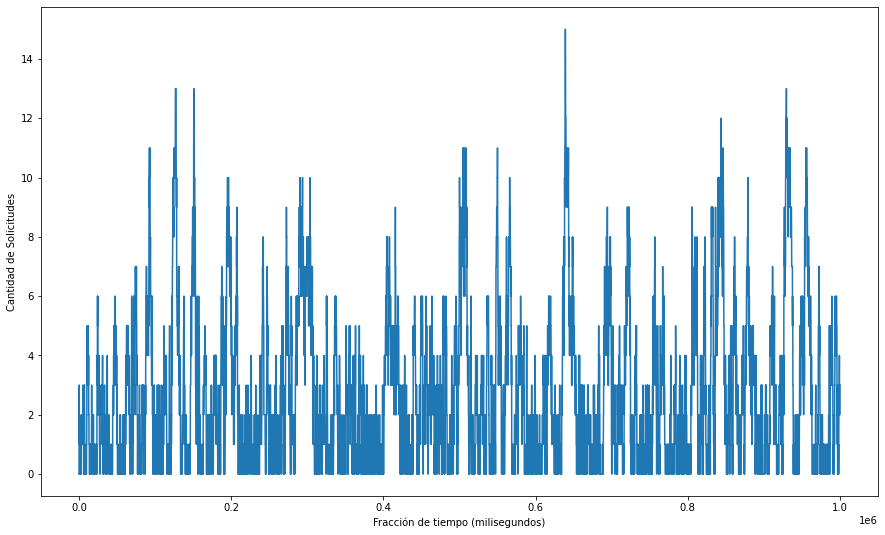

In [153]:
print("b. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.")
plt.figure(figsize=(15,9))
plt.plot(tiempos,cant_solicitudes_x_fraccion)
plt.xlabel('Fracción de tiempo (milisegundos)')
plt.ylabel('Cantidad de Solicitudes')

El sistema no llega a saturarse (el máximo de solicitudes se encuentra alrededor de 15 cuando el máximo soportado es 30), esto podría deberse a que la probabilidad de egreso del sistema es mayor a la probabilidad de arribo

__d.__ Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado


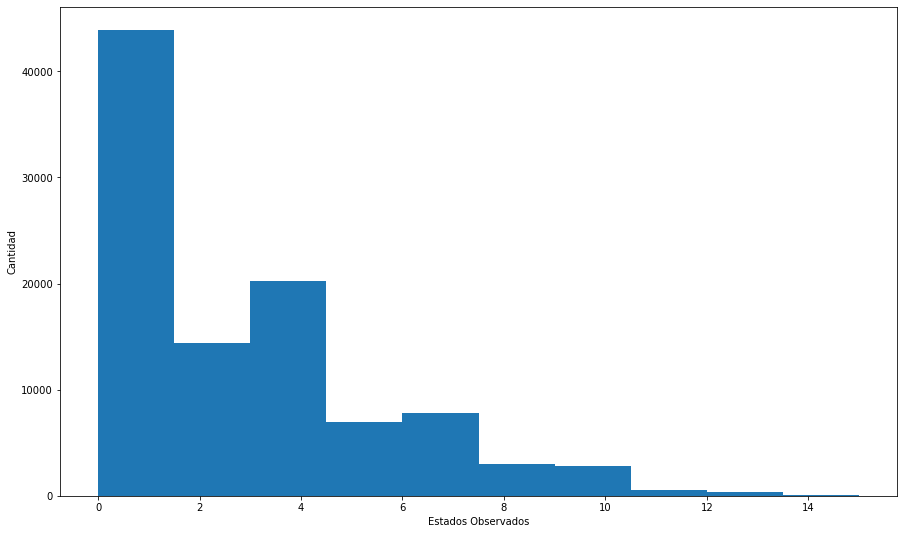

In [154]:
print("d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado")
plt.figure(figsize=(15,9))
plt.hist(cant_solicitudes_x_fraccion)
plt.xlabel('Estados Observados')
plt.ylabel('Cantidad')
plt.show()

__e.__ Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

Consideramos que el servidor no procesa solicitudes en aquellos momentos en los cuales el estado = 0.

Pasamos el tiempo en el que el sistema no procesó solicitudes a segundos y calculamos el porcentaje que representa respecto del total de 1000 segundos

In [144]:
print(str(((tiempo_sin_solicitudes / 1000) * 100) / 1000) + "%")

23.896%
